### Imports

In [1]:
import matplotlib.pyplot as plt
from fmpy import *
import numpy as np
import pandas as pd
import boto3
import json
import os
import glob

### Upload FMU files to S3 bucket
- BouncingBall.fmu - the FMU archive you want to simulate (must be compiled for linux64 platform or the simulation will fail)
- BouncingBall_pSets.json - the set of model parameters (values that are constant for each simulation loop)
- BouncingBall_iSet.json - the set of time series inputs for the model (time series interpolation)
- Note, the BouncingBall does not have any inputs, so the iSet file is an empty JSON

In [2]:
# instantiate boto3 s3 client
s3_client = boto3.client('s3')
bucket_name = 'fmpy-bucket'
# upload the files (name of the local file, name of bucket, the name you want for the file in s3)
s3_client.upload_file('BouncingBall.fmu', bucket_name, 'BouncingBall.fmu')
s3_client.upload_file('BouncingBall_pSets.json', bucket_name, 'BouncingBall_pSets.json')
s3_client.upload_file('BouncingBall_iSet.json', bucket_name, 'BouncingBall_iSet.json')

### Lambda inputs


https://hands-on.cloud/working-with-aws-lambda-in-python-using-boto3/#:~:text=To%20invoke%20the%20Lambda%20function,should%20contain%20JSON%20string%20data.
- Each parameter set defines 1 instance of the model
- If there are multiple parameter sets, can upload all at once (params, inputs, fmu file)
- Trigger lambdas based on those files
- Example: {
    'parameter_file': 'BouncingBall_pSets.json',
    'input_file': 'BouncingBall_iSet.json',
    'fmu_file': 'BouncingBall.fmu',
    'step_size': 0.01
}
- When invoking the Lambda, we can provide it some input data such as model start time, end time, and which json files to use. Note, all the inputs shown in the cell below are required for the simulation to run




The Lambda takes the following inputs:
- parameter_file: JSON file describing model parameter names and values (are constant for each simulation run)
- input_file: JSON file describing model input names and values (can be time series inputs)
- fmu_file: the name of the FMU file you want to simulate on S3
- start_time: simulation start time
- end_time: simulation end time
- index: used when a for loop invokes Lambdas in parallel (set index to 1 if only running one simulation)

In [3]:
# define data to send to lambda as inputs
lambda_client = boto3.client('lambda')
# all times are in seconds
simulate_event = {'parameter_file': 'BouncingBall_pSets.json',
    'input_file': 'BouncingBall_iSet.json',
    'fmu_file': 'BouncingBall.fmu',
    'start_time': 0,
    'end_time': 10,
    'step_size': 0.01,
    'index': 1}


### Invoke the Lambda
- Now we will invoke (trigger) one instance of the Lambda using the simulate_event inputs
- When finished, it will return the runtime, status code 200, and a success message
- If it failed, it will return the relevant error message
- Note, if you see a message about the simulation timing out or running out of memory, adjust the settings in the Lambda configuration page

In [4]:
# invoke the lambda with the input data using the payload argument
response = lambda_client.invoke(
  FunctionName='simulateCoupledClutches',
  Payload=json.dumps(simulate_event),
)
print(response['Payload'])
print(response['Payload'].read().decode("utf-8"))

{"runtime": "0.8567090034484863 second(s)", "statusCode": 200, "body": "\"Ran successfully!\""}


### Download latest CSV file
- To plot the results, let's download the latest CSV file that was put into the S3 results bucket onto a local machine

In [4]:
# get the latest object from the s3 results bucket
fmu_name = 'BouncingBall.fmu'
results_bucket = 'simulate-fmu-results-bucket'
def download_latest_file(fmu_name):
    s3_client = boto3.client('s3')
    response = s3_client.list_objects_v2(Bucket='simulate-fmu-results-bucket')
    objects = sorted(response['Contents'], key=lambda obj: obj['LastModified'])
    ## Latest object
    latest_object = objects[-1]['Key']
    filename = latest_object[latest_object.rfind('/')+1:] # Remove path
    # Download it to current directory
    s3_client.download_file(results_bucket, latest_object, filename)
    

In [16]:
download_latest_file(fmu_name)

In [17]:
# get the name of the newest file in the current directory
list_of_files = glob.glob(fmu_name + '*_Results_Run*.csv') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

BouncingBall.fmu_2022_07_16_21_46_15_Results_Run1.csv


### Plot the results
- Read data into Pandas dataframe
- Plot the variables with respect to time using matplotlib

In [18]:
# read the csv into a pandas dataframe then print the first 10 lines
df = pd.read_csv(latest_file)
df.head(10)

,time,g,h,v
0,0.01,-9.8,0.999559,-0.098
1,0.02,-9.8,0.998138,-0.196
2,0.03,-9.8,0.995737,-0.294
3,0.04,-9.8,0.992356,-0.392
4,0.05,-9.8,0.987995,-0.490
5,0.06,-9.8,0.982654,-0.588
6,0.07,-9.8,0.976333,-0.686
7,0.08,-9.8,0.969032,-0.784
8,0.09,-9.8,0.960751,-0.882
9,0.10,-9.8,0.951490,-0.980


Text(0, 0.5, 'Gravity')

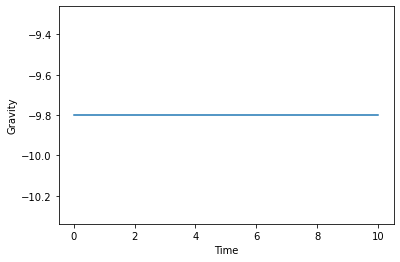

In [19]:
# plot parameters
plt.plot(df['time'],df['g'])
plt.xlabel("Time")
plt.ylabel("Gravity")

Text(0, 0.5, 'Height of ball')

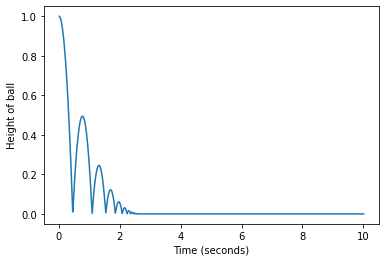

In [20]:
# plot height of ball
plt.plot(df['time'],df['h'])
plt.xlabel("Time (seconds)")
plt.ylabel("Height of ball")

Text(0, 0.5, 'Velocity of ball (m/s)')

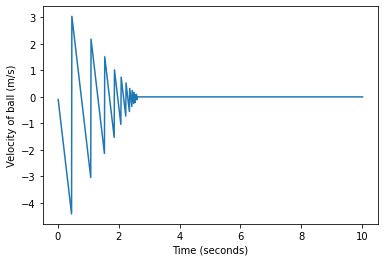

In [21]:
# plot velocity
plt.plot(df['time'],df['v'])
plt.xlabel("Time (seconds)")
plt.ylabel("Velocity of ball (m/s)")

### Print a report of the simulation

In [22]:
# print report of the simulation after downloading the report file
# need to manually specify name of file to download for boto3
# for example 
result_filename = "BouncingBall.fmu_2022_07_14_22_06_17_Report_Run1.csv"
s3_client.download_file(results_bucket, result_filename, result_filename)

#list_of_files = glob.glob('*_Report.csv') # * means all if need specific format then *.csv
#latest_file = max(list_of_files, key=os.path.getctime)
#print(latest_file)


In [23]:
# print the report
df_report = pd.read_csv(result_filename)
df_report.head()

,FMU file,Start date,End date,Simulation start time,Simulation end time,Total runtime,Real time factor (sim. time / real time)
0,BouncingBall.fmu,2022_07_14_22_06_17,2022_07_14_22_06_17,0,10,0.892293,11.207078


### Simulate using a sweep of parameters
- Each pSets.json contains the parameters for a model (and only that model) for one simulation run.
- Let's say we want to simulate BouncingBall.fmu 100 times.
- So we need to create 100 pSets.json files and upload them to fmpy-bucket on S3.
- By default, Python will wait for each Lambda execution to finish before starting the next one. However, this is slow so let's run them asynchronously (without waiting for a response).

In [29]:
s3_client.upload_file('BouncingBall.fmu', 'fmpy-bucket', 'BouncingBall.fmu')
s3_client.upload_file('BouncingBall_iSet.json', 'fmpy-bucket', 'BouncingBall_iSet.json')

# upload all 100 pSets
# setting g to the same value in each pSet file for now
# although you could change the value in each pSet file to see the affect on the height of the ball
for i in range(100):
    j = str(i+1)
    pSets = 'BouncingBall_pSets_' + j + '.json'
    f = open(pSets, "w")
    f.write("{\"g\":-9.8}")
    f.close()
    s3_client.upload_file(pSets, 'fmpy-bucket', pSets)


- Looping 10 times, each time increasing the input pSets file by 1 using an interator

In [25]:
# define data to send to lambda as inputs
lambda_client = boto3.client('lambda')

for i in range(100):
    # all times are in seconds
    # for iterating through the files
    j = str(i+1)
    pSets = 'BouncingBall_pSets_' + j + '.json'
    simulate_event = {'parameter_file': pSets,
        'input_file': 'BouncingBall_iSet.json',
        'fmu_file': 'BouncingBall.fmu',
        'start_time': 0,
        'end_time': 10,
        'threshold': 3,
        'step_size': 0.01,
        'index': j}
    # invoke the lambda with the input data using the payload argument
    # InvocationType - https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/lambda.html#:~:text=To%20invoke%20a%20function%20asynchronously%2C%20set%20InvocationType%20to%20Event%20.
    response = lambda_client.invoke(
        FunctionName='simulateCoupledClutches',
        InvocationType='Event',
        Payload=json.dumps(simulate_event),
    )
    #print(response['Payload'])
    #print(response['Payload'].read().decode("utf-8"))
    # for some reason, trying to print the above results in blank lines


- #### NOTE: downloads ALL files from the S3 bucket


In [30]:
#### NOTE: downloads ALL files from the S3 bucket
s3_resource = boto3.resource('s3')

my_bucket = s3_resource.Bucket(results_bucket)

for s3_object in my_bucket.objects.all():
    path, filename = os.path.split(s3_object.key)
    my_bucket.download_file(s3_object.key, filename)
    


In [31]:
# plotting 3 from a previous simulation as an example 
# (where the gravity value increased by 1 each time, making the ball bounce slower)
df_sweep_ball_1 = pd.read_csv('BouncingBall.fmu_2022_07_14_22_07_21_Results_Run1.csv')
df_sweep_ball_2 = pd.read_csv('BouncingBall.fmu_2022_07_14_22_07_23_Results_Run5.csv')
df_sweep_ball_3 = pd.read_csv('BouncingBall.fmu_2022_07_14_22_07_24_Results_Run10.csv')
df_sweep_ball_1.head()

,time,g,h,v
0,0.01,-9.8,0.999559,-0.098
1,0.02,-9.8,0.998138,-0.196
2,0.03,-9.8,0.995737,-0.294
3,0.04,-9.8,0.992356,-0.392
4,0.05,-9.8,0.987995,-0.490


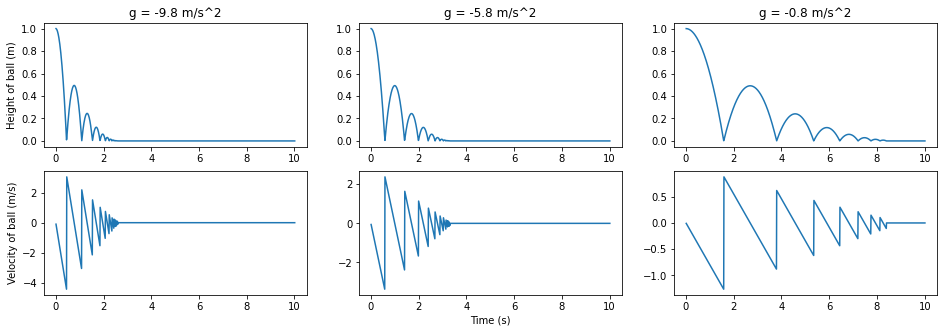

In [32]:
# matplotlib subplot
# plots time against velocity and height for all 3 dataframes
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,5))
axs[0, 0].plot(df_sweep_ball_1['time'], df_sweep_ball_1['h'])
axs[0, 0].set_ylabel('Height of ball (m)')
axs[0, 0].set_title('g = -9.8 m/s^2')
axs[0, 1].plot(df_sweep_ball_2['time'], df_sweep_ball_2['h'])
axs[0, 1].set_title('g = -5.8 m/s^2')
axs[0, 2].plot(df_sweep_ball_3['time'], df_sweep_ball_3['h'])
axs[0, 2].set_title('g = -0.8 m/s^2')
axs[1, 0].plot(df_sweep_ball_1['time'], df_sweep_ball_1['v'])
axs[1, 0].set_ylabel('Velocity of ball (m/s)')
axs[1, 1].plot(df_sweep_ball_2['time'], df_sweep_ball_2['v'])
axs[1, 1].set_xlabel('Time (s)')
axs[1, 2].plot(df_sweep_ball_3['time'], df_sweep_ball_3['v'])

### Real time factor (RTF)
- Important to note this value for each model you simulate (there is a tradeoff between simulation accuracy and speed)
- Higher fidelity models will likely have a lower RTF (< 1), however running the Lambdas in parallel aims to improve this

In [81]:
# get all the Bouncing ball report files in the current directory
csv_files = glob.glob("BouncingBall.fmu_*_Report_Run*.csv")
#print(csv_files)
df_list = (pd.read_csv(file) for file in csv_files)
# merge the CSVs into one large dataframe
big_df = pd.concat(df_list, ignore_index=True)

#print(big_df)
# to truncate list to length 100, in case there are more than 100 files in the bucket
n = len(big_df) - 100
big_df.drop(big_df.tail(n-0).index,
        inplace = True)

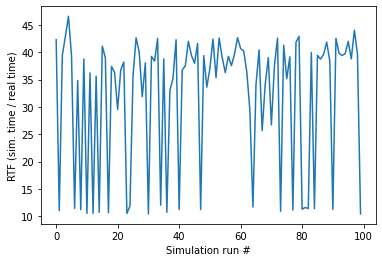

In [82]:
# plotting
rtf_array = big_df['Real time factor (sim. time / real time)']
plt.plot(rtf_array)
plt.ylabel('RTF (sim. time / real time)')
plt.xlabel('Simulation run #')
# seem like some simulations run faster than others
plt.savefig('AWS_RTF_Graph_BouncingBall_100Runs.png')

In [83]:
# find average RTFm over the simulation runs
sum_rtf = 0
for i in rtf_array:
    sum_rtf = sum_rtf + i
average_rtf = sum_rtf/len(rtf_array)
print('Average RTF for Lambda runs:', average_rtf)

Average RTF for Lambda runs: 32.19408581323855


### More complex model
- DiscreteController.fmu
- The dump() function prints out model info

In [33]:
# print out model information
fmu_name = 'DiscreteController'
dump(fmu_name + '.fmu')


Model Info

  FMI Version        2.0
  FMI Type           Model Exchange
  Model Name         sb_DCMotor_Controller
  Description         
  Platforms          linux64
  Continuous States  3
  Event Indicators   0
  Variables          60
  Generation Tool    Activate
  Generation Date    2020-11-17T14:41:10Z

Default Experiment

  Stop Time          10.0
  Tolerance          1e-06
  Step Size          0.001

Variables (input, output)

  Name               Causality              Start Value  Unit     Description
  DCMotor_angle      output                                       index:57 ,output variable:SCSREAL_COP
  DCMotot_speed      output                                       index:58 ,output variable:SCSREAL_COP
  controller_output  output                                       index:59 ,output variable:SCSREAL_COP
  Reference_angle    input                          0.0           index:60 ,input variable:SCSREAL_COP


- Grabbing inputs and parameters to add to the JSON files

In [34]:
# print out all variables, including parameters
model_description = read_model_description(fmu_name + '.fmu')

vrs = {}
for variable in model_description.modelVariables:
    vrs[variable.name] = variable.valueReference
print('All parameters:', vrs)

All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.opar2': 7, 'Gain_2.opar1': 16, 'Gain_1.opar3': 6, 'Gain_1.opar2': 5, '

- Need to replace single quotes with double quotes, otherwise the Lambda won't be able to read the JSON

In [8]:
# create iSet and pSets files with example values
# could also use a loop to create many JSON files with different input values
discrete_iset = str({"Reference_angle": 3.14159})
discrete_pset = str({})
discrete_iset = discrete_iset.replace("\'", "\"")
discrete_pset = discrete_pset.replace("\'", "\"")
# write to new json files
with open(fmu_name + '_pSets.json', 'w') as f:
    f.write(str(discrete_pset))
with open(fmu_name + '_iSet.json', 'w') as f:
    f.write(str(discrete_iset))

- Uploading new files to S3

In [9]:
# upload to S3
s3_client.upload_file(fmu_name + '.fmu', 'fmpy-bucket', fmu_name + '.fmu')
s3_client.upload_file(fmu_name + '_iSet.json', 'fmpy-bucket', fmu_name + '_iSet.json')
s3_client.upload_file(fmu_name + '_pSets.json', 'fmpy-bucket', fmu_name + '_pSets.json')


- Running the simulation 100 times asynchronously 

In [14]:
for i in range(100):
    index = i+1

    simulate_event = {'parameter_file': fmu_name + '_pSets.json',
            'input_file': fmu_name + '_iSet.json',
            'fmu_file': fmu_name + '.fmu',
            'start_time': 0,
            'end_time': 10,
            'threshold': 3,
            'step_size': 0.01,
            'index': str(index)}

    response = lambda_client.invoke(
            FunctionName='simulateCoupledClutches',
            InvocationType='Event',
            Payload=json.dumps(simulate_event),
        )
    print(response['Payload'])
    print(response['Payload'].read().decode("utf-8"))

- Download results and plot 

In [15]:
# Note: downloads ALL files from the S3 bucket
# uncomment below only if you don't already have result files for DiscreteController on your local machine

#s3_resource = boto3.resource('s3')

#my_bucket = s3_resource.Bucket(results_bucket)

#for s3_object in my_bucket.objects.all():
#    path, filename = os.path.split(s3_object.key)
#    my_bucket.download_file(s3_object.key, filename)
 

In [23]:
# print report of the simulation
list_of_files = glob.glob('DiscreteController*_Results_Run*.csv')
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

DiscreteController.fmu_2022_07_17_00_31_27_Results_Run99.csv


Text(0.5, 1.0, 'DC Motor Angle')

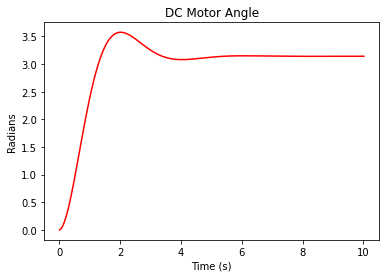

In [25]:
df2 = pd.read_csv(latest_file)
plt.plot(df2['time'], df2['DCMotor_angle'], label="DC Motor angle", color="red")
plt.xlabel('Time (s)')
plt.ylabel('Radians')
plt.title('DC Motor Angle')
#plt.legend()

Text(0.5, 1.0, 'DC Motor Speed')

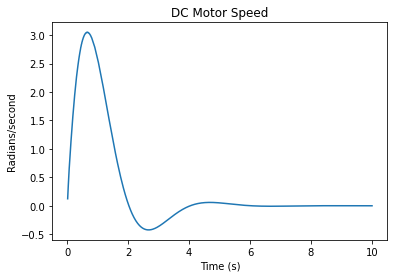

In [26]:
plt.plot(df2['time'], df2['DCMotot_speed'], label="DC Motor speed")
plt.xlabel('Time (s)')
plt.ylabel('Radians/second')
plt.title('DC Motor Speed')

Text(0.5, 0, 'Time (s)')

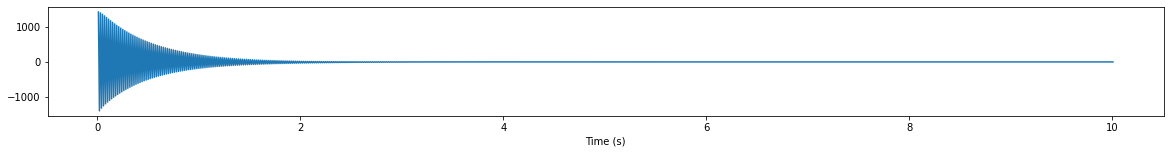

In [27]:
# plot controller output
fig = plt.figure(figsize=(20, 2))
ax = fig.add_subplot(111)
ax.plot(df2['time'], df2['controller_output'])
ax.set_xlabel('Time (s)')

### RTF plotting for more complex model

In [2]:
# get all the Bouncing ball report files in the current directory
csv_files = glob.glob("DiscreteController.fmu_*_Report_Run*.csv")
#print(csv_files)
df_list = (pd.read_csv(file) for file in csv_files)
# merge the CSVs into one large dataframe
big_df = pd.concat(df_list, ignore_index=True)

#print(big_df)
# to truncate list to length 100
n = len(big_df) - 100
big_df.drop(big_df.tail(n-0).index,
        inplace = True)

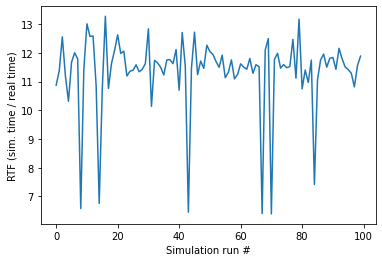

In [3]:
# plotting
# may go over 100 simulation runs due to additional csv files present from previous runs
rtf_array = big_df['Real time factor (sim. time / real time)']
plt.plot(rtf_array)
plt.ylabel('RTF (sim. time / real time)')
plt.xlabel('Simulation run #')
# seem like some simulations run faster than others
plt.savefig('AWS_RTF_Graph_DiscreteController_100Runs.png')

In [5]:
# calculating average RTF
sum_rtf = 0
for i in rtf_array:
    sum_rtf = sum_rtf + i
average_rtf = sum_rtf/len(rtf_array)
print('Average RTF for Lambda runs:', average_rtf)

Average RTF for Lambda runs: 11.359903974721169
